# Stratified QG Vortex Stability in Firdrake

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Linear Stability Problem

$$
c\left[ \frac{1}{r}\partial_r\left(r\partial_r\right) - \frac{m^2}{r^2} + \frac{1}{Bu^2}\partial_{zz} \right]\widehat{\psi} = 
\left[ \frac{1}{r}\partial_r\Psi \left( \frac{1}{r}\partial_r\left(r\partial_r\right) - \frac{m^2}{r^2} + \frac{1}{Bu^2}\partial_{zz} \right) - \frac{1}{r}\partial_rQ \right]\widehat{\psi}
$$

### Weak form

Multiply the linear stability problem by $r^2$ to remove the singularities, multiply by the test function $\phi$, and integrate over $r,z$.

***Note that $\partial_r\Psi = U_\theta$.***

***Note the extra factor of $r$ from $dA$***

***Note: boundary condition terms are currently utterly ignored***

***Note: need to add beta***

\begin{align*}
c \iint r^3\phi \left[ \frac{1}{r}\partial_r\left(r\partial_r\right) - \frac{m^2}{r^2} + \frac{1}{Bu^2}\partial_{zz} \right]\widehat{\psi} \, dr \, dz
&= \iint r^3\phi \left[ \frac{1}{r}\partial_r\Psi \left( \frac{1}{r}\partial_r\left(r\partial_r\right) - \frac{m^2}{r^2} + \frac{1}{Bu^2}\partial_{zz}\right) - \frac{1}{r}\partial_rQ \right]\widehat{\psi} \, dr \, dz\\
~
c \iint \phi \left[ r^2\partial_r\left(r\partial_r\right) - rm^2 + r^3\frac{1}{Bu^2}\partial_{zz} \right]\widehat{\psi} \, dr \, dz
&= \iint \phi \left[ \partial_r\Psi \left( r\partial_r\left(r\partial_r\right) - m^2 + r^2\frac{1}{Bu^2}\partial_{zz}\right) - r^2\partial_rQ \right]\widehat{\psi} \, dr \, dz\\
~
c \iint \phi r^2\partial_r\left(r\partial_r\widehat{\psi}\right) - r\phi m^2\widehat{\psi} + r^3\frac{1}{Bu^2}\phi\partial_{zz}\widehat{\psi} \, dr \, dz
&= \iint U_\theta \left( \phi r\partial_r\left(r\partial_r\widehat{\psi}\right) - \phi m^2\widehat{\psi} + r^2\frac{1}{Bu^2}\phi\partial_{zz}\widehat{\psi} \right) - \phi r^2\partial_rQ \widehat{\psi} \, dr\, dz \\
~
c \iint \partial_r(r^2\phi)\cdot(r\partial_r\psi) + rm^2\phi\widehat{\psi} + r^3\frac{1}{Bu^2}\partial_z\phi\partial_z\widehat{\psi} \, dr \, dz
&= \iint  \partial_r(r\phi U_\theta)\cdot(r\partial_r\psi) +  U_\theta m^2\widehat{\psi}\phi + r^2\frac{1}{Bu^2}\partial_z(U_\theta\phi)\partial_z\widehat{\psi} + \phi r^2\partial_rQ \widehat{\psi} \, dr\, dz
\end{align*}


In [2]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from firedrake import *
from firedrake.petsc import PETSc
try:
    from slepc4py import SLEPc
except ImportError:
    import sys
    warning("Unable to import SLEPc, eigenvalue computation not possible (try firedrake-update --slepc)")
    sys.exit(0)

In [3]:
# Define the Mesh

Lh = 1.
Lv = 1.

Lr   = Lh*5
Lz   = Lv*10

U0   = 1.0

nr   = 40
nz   = 40

mesh = RectangleMesh(nr, nz, Lr, Lz)
x    = SpatialCoordinate(mesh)

# Define parameters
beta = Constant('0.0')

In [4]:
# Order of the solution
p = 0

# Define CG function space
V  = FunctionSpace(mesh, 'CG', p+2)

# Impose zero Dirichlet Boundary Conditions
bc = [DirichletBC(V, 0.0, 1),
      DirichletBC(V, 0.0, 2)]

# Define modes 
emodes_real, emodes_imag = Function(V), Function(V)

In [5]:
# Define test and trial functions
phi, psi = TestFunction(V), TrialFunction(V)

In [6]:
# Define Petsc options
opts = PETSc.Options()
opts.setValue("eps_gen_non_hermitian", None)
opts.setValue("st_pc_factor_shift_type", "NONZERO")

#opts.setValue("st_type", "sinvert")
#opts.setValue("eps_target", 0.01319279)

opts.setValue("eps_type", "krylovschur")
opts.setValue("eps_largest_imaginary", None)
opts.setValue("eps_tol", 1e-10)

$$
c \iint \partial_r(r^2\phi)\cdot(r\partial_r\psi) + rm^2\phi\widehat{\psi} + r^3\frac{1}{Bu^2}\partial_z\phi\partial_z\widehat{\psi} \, dr \, dz
= \iint  \partial_r(r\phi U_\theta)\cdot(r\partial_r\psi) +  U_\theta m^2\widehat{\psi}\phi + r^2\frac{1}{Bu^2}\partial_z(U_\theta\phi)\partial_z\widehat{\psi} + \phi r^2\partial_rQ \widehat{\psi} \, dr\, dz
$$

In [7]:
num_eigenvalues = 1

# Wavenumber
ktheta = 1
k  = Constant('{0:g}'.format(ktheta*1.0))
k2 = Constant(k**2)

# Burger
NBu = 50
Bus = np.logspace(-2,2,NBu)
#Bus = [5.]

egs_re  = np.zeros((NBu, num_eigenvalues))
egs_im  = np.zeros((NBu, num_eigenvalues))
iters   = np.zeros((NBu, num_eigenvalues))

modes_re = [[]]*NBu
modes_im = [[]]*NBu

cnt = 0
for bu in Bus:

    Bu   = Constant('{0:g}'.format(bu))
    Bu2  = Constant('{0:g}'.format(bu**2))
    
    # Background State
    #Psib = Function(V).interpolate( -0.25 * U0 * Lh   * exp( -x[0]**2 - (x[1] - Lz/2.)**2) )
    Ub   = Function(V).interpolate(  0.5  * U0 * x[0] * exp( -x[0]**2 - (x[1] - Lz/2.)**2) )
    #Qb   = Function(V).interpolate( -U0/Lh*(x[0]**2 - 1 + ((x[1]-Lz/2)**2 - 0.5)/Bu2 )*exp( -x[0]**2 - (x[1] - Lz/2.)**2) )
    dQb  = Function(V).interpolate( 2*U0*x[0]/(Lh**2)*(x[0]**2 - 2 + ((x[1]-Lz/2)**2 - 0.5)/Bu2 )*exp( -x[0]**2 - (x[1] - Lz/2.)**2) )
    

    ##
    ## Define Weak form
    ##
    
    # LHS
    m = (  ((x[0]**2*phi).dx(0)) *  (x[0]*(psi.dx(0)))  \
         +   x[0] * k2 * phi * psi    \
         +   x[0]**3 * (phi.dx(1)) * (psi.dx(1)) / Bu2 \
        )*dx
    
    # RHS
    a = (  ((x[0]*phi*Ub).dx(0)) * (x[0]*(psi.dx(0)))  \
         + Ub * k2 *  phi *  psi    \
         + x[0]**2 * ((Ub*phi).dx(1)) * (psi.dx(1)) / Bu2 \
         + x[0]**2 * phi * dQb * psi
        )*dx
    

    petsc_a = assemble(a).M.handle
    petsc_m = assemble(m, bcs=bc).M.handle

    # Define Solver options
    es = SLEPc.EPS().create(comm=COMM_WORLD)
    es.setDimensions(num_eigenvalues)
    es.setOperators(petsc_a, petsc_m)
    es.setFromOptions()
    es.solve()

    nconv = es.getConverged()
    its = es.getIterationNumber()
    
    #if (nconv == 0):
    #    print("Failed to converge for k = {0:.3g}".format(k))
        
    imax = min(nconv, num_eigenvalues)
    #modes_re[cnt] = [Function(V)]*(imax+1)
    #modes_im[cnt] = [Function(V)]*(imax+1)
    
    for i in range(imax):
        vr, vi = petsc_a.getVecs()

        lam = es.getEigenpair(i, vr, vi)
        
        egs_re[cnt,i] = k*lam.real
        egs_im[cnt,i] = k*lam.imag
        iters[cnt,i]  = its
        
        # Normalize and store eigenvectors
        #tmp = vr.array + 1j*vi.array
        #max_ind = np.argmax(np.abs(tmp))
        #tmp = tmp/tmp[max_ind]
        
        #modes_re[cnt][i].vector()[:] = tmp.real
        #modes_im[cnt][i].vector()[:] = tmp.imag
        
    for i in range(imax,num_eigenvalues):
        egs_re[cnt,i] = np.nan
        egs_im[cnt,i] = np.nan
        iters[cnt,i]  = np.nan
        
    print("{0:02d}: Bu = {1:.2g} : sigma = {2:.2g} : {3:g} iters".format(cnt, bu, egs_im[cnt,0], iters[cnt,0]))
    
    cnt += 1
    
print('Done!')

00: Bu = 0.01 : sigma = 0.14 : 19 iters
01: Bu = 0.012 : sigma = 0.14 : 18 iters
02: Bu = 0.015 : sigma = 0.14 : 19 iters
03: Bu = 0.018 : sigma = 0.13 : 17 iters
04: Bu = 0.021 : sigma = 0.13 : 18 iters
05: Bu = 0.026 : sigma = 0.12 : 18 iters
06: Bu = 0.031 : sigma = 0.12 : 18 iters
07: Bu = 0.037 : sigma = 0.11 : 21 iters
08: Bu = 0.045 : sigma = 0.1 : 19 iters
09: Bu = 0.054 : sigma = 0.092 : 19 iters
10: Bu = 0.066 : sigma = 0.082 : 20 iters
11: Bu = 0.079 : sigma = 0.072 : 20 iters
12: Bu = 0.095 : sigma = 0.059 : 26 iters
13: Bu = 0.12 : sigma = 0.048 : 22 iters
14: Bu = 0.14 : sigma = 0.037 : 24 iters
15: Bu = 0.17 : sigma = 0.028 : 33 iters
16: Bu = 0.2 : sigma = 0.018 : 49 iters
17: Bu = 0.24 : sigma = 0.0095 : 124 iters
18: Bu = 0.29 : sigma = 0.00059 : 105 iters
19: Bu = 0.36 : sigma = 0.00049 : 126 iters
20: Bu = 0.43 : sigma = 0.0004 : 121 iters
21: Bu = 0.52 : sigma = 0.00032 : 151 iters
22: Bu = 0.63 : sigma = 0.00026 : 155 iters
23: Bu = 0.75 : sigma = 0.00021 : 229 it

In [8]:
np.savez("Nr{0:d}Nz{1:d}p{2:d}kt{3:d}".format(nr,nz,p,ktheta), egs_im = egs_im, egs_re = egs_re, iters = iters, Bus = Bus)
print("Nr{0:d}Nz{1:d}p{2:d}kt{3:d}".format(nr,nz,p,ktheta))

Nr40Nz40p0kt1


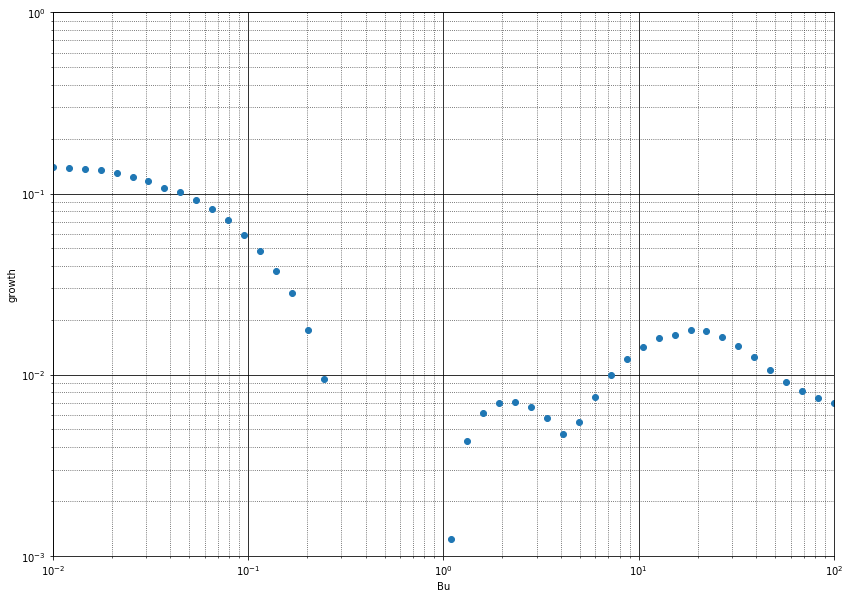

In [9]:
plt.figure(figsize=(14,10))
plt.plot(Bus, egs_im[:,0], 'o')
plt.xlabel('Bu')
plt.ylabel('growth')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.ylim(1e-3, 1e-0)
plt.xlim(1e-2, 1e2)
plt.grid('on', which='major', ls='-', color='0')
plt.grid('on', which='minor', ls=':', color='0.25')
plt.show()

In [10]:
Bi = 32
si = 0
print(Bus[Bi])
#ax1 = plot(modes_re[Bi][si], vmin=-1, vmax=1, cmap='seismic')
#ax2 = plot(modes_im[Bi][si], vmin=-1, vmax=1, cmap='seismic')

4.09491506238
